In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from category_encoders import OneHotEncoder, BinaryEncoder
from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

n_splits = 10
seed = 42
np.random.seed(seed)

k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

#### 1 Read and describe data

In [2]:
matches_df = pd.read_csv("../../../data_for_training/arsenal.csv")
matches_df.columns

Index(['result', 'venue', 'season', 'win_percent_before_team2',
       'win_percent_diff', 'draw_percent_before_team2',
       'lose_percent_before_team2', 'head2head_win_percent',
       'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6',
       'ELO_before_match_team2', 'ELO_before_diff',
       'average_score_before_match_team1', 'average_score_before_match_team2',
       'average_score_before_match_diff'],
      dtype='object')

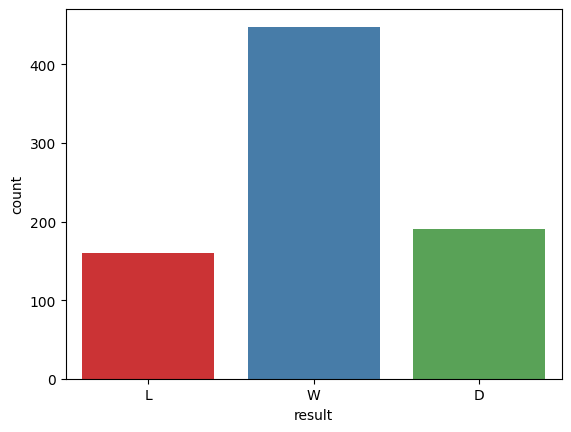

In [3]:
matches_df = matches_df.drop(
    columns=[
        "average_score_before_match_team1",
        "average_score_before_match_diff",
        "draw_percent_before_team2",
    ]
)

sns.countplot(x="result", data=matches_df, palette="Set1");

In [4]:
matches_df.columns

Index(['result', 'venue', 'season', 'win_percent_before_team2',
       'win_percent_diff', 'lose_percent_before_team2',
       'head2head_win_percent', 'head2head_draw_percent',
       'head2head_lost_percent', 'is_opponent_big6', 'ELO_before_match_team2',
       'ELO_before_diff', 'average_score_before_match_team2'],
      dtype='object')

### Phân chia dữ liệu thành X, y

In [5]:
X = matches_df.drop("result", axis=1)
X.head()

,venue,season,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2
0,Away,2000-2001,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,1500.000000,0.000000,0.000000
1,Home,2000-2001,1.000000,-1.000000,0.000000,0.0,0.0,0.0,1,1531.250000,-62.500000,3.000000
2,Home,2000-2001,0.500000,0.000000,0.500000,0.0,0.0,0.0,0,1513.545664,-0.621645,1.500000
3,Away,2000-2001,0.333333,0.333333,0.333333,0.0,0.0,0.0,1,1507.852086,42.639029,1.333333
4,Away,2000-2001,0.250000,0.250000,0.500000,0.0,0.0,0.0,0,1456.587085,96.956843,1.000000


In [6]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(matches_df["result"])

In [7]:
# Xác định các cột phân loại và cột số
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

numerical_cols, categorical_cols

(Index(['win_percent_before_team2', 'win_percent_diff',
        'lose_percent_before_team2', 'head2head_win_percent',
        'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6',
        'ELO_before_match_team2', 'ELO_before_diff',
        'average_score_before_match_team2'],
       dtype='object'),
 Index(['venue', 'season'], dtype='object'))

#### Encoding cho các đặc trưng

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ("venue", OneHotEncoder(use_cat_names=True), ["venue"]),
        ("season", BinaryEncoder(), ["season"]),
        ('num', StandardScaler(), numerical_cols),
    ]
)

transformed_X = preprocessor.fit_transform(X)

# Hiển thị dữ liệu sau khi tiền xử lý
columns = (
    list(preprocessor.named_transformers_["venue"].get_feature_names_out())
    + list(preprocessor.named_transformers_["season"].get_feature_names_out())
    + numerical_cols.tolist()
)

transformed_X = pd.DataFrame(transformed_X, columns=columns)
transformed_X.head()

,venue_Away,venue_Home,season_0,season_1,season_2,season_3,season_4,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.369793,-0.509837,-1.430191,-1.962036,-1.160168,-0.949541,-0.595178,0.026866,-0.823808,-1.807943
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.398592,-3.386673,-1.430191,-1.962036,-1.160168,-0.949541,1.680169,0.156146,-1.023563,2.241178
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.514399,-0.509837,0.549578,-1.962036,-1.160168,-0.949541,-0.595178,0.082904,-0.825795,0.216618
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.113665,0.449108,-0.110345,-1.962036,-1.160168,-0.949541,1.680169,0.059350,-0.687531,-0.008334
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.427697,0.209372,0.549578,-1.962036,-1.160168,-0.949541,-0.595178,-0.152731,-0.513927,-0.458236


In [9]:
X = transformed_X

### Thử nghiệm các mô hình

In [11]:
algorithms = [
    ("LR", LogisticRegression(random_state=seed, class_weight="balanced")),
    (
        "RF",
        RandomForestClassifier(
            n_estimators=100, random_state=seed, class_weight="balanced"
        ),
    ),
]

cv_results = {}

for name, model in algorithms:
    # Thực hiện cross-validation
    cv_scores = cross_val_score(model, X, y, cv=k_fold, scoring="accuracy")
    cv_results[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    print(f"Accuracy {name}: {score}")

Accuracy LR: 0.49560126582278474
Accuracy RF: 0.564509493670886


### Chọn bộ siêu tham số

#### SVC

In [16]:
best_params_SVC = {}
models_tuned_SVC = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("SVC", SVC(probability=True)),
]

# Define parameter grid with correct keys
param_grid = {
    "SVC": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],  # Expanded C range
        "gamma": [0.001, 0.01, 0.1, 1, 10, 100],  # More granular gamma range
        "kernel": ["linear", "poly", "rbf", "sigmoid"],  # Added kernel options
        "class_weight": ["balanced"]
    }
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=5, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_SVC[name] = randomized_search.best_params_
        models_tuned_SVC[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


Model processing:  SVC
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [17]:
with open('best_params/best_params_SVC.json', 'w') as f:
    json.dump(best_params_SVC, f)

#### RF

In [12]:
best_params_RF = {}
models_tuned_RF = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ('RF', RandomForestClassifier()),
]

# Define parameter grid with correct keys
param_grid = {
    "RF": {
        "n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
        "max_features": ["sqrt", "log2", 0.2, 0.4, 0.6],
        "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
        "min_samples_split": [2, 5, 10, 20],
        "min_samples_leaf": [1, 2, 4, 6],
        "class_weight": ["balanced"]
    }
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,
            cv=k_fold, 
            scoring='accuracy', 
            random_state=seed,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_RF[name] = randomized_search.best_params_
        models_tuned_RF[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


Model processing:  RF
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [13]:
best_params_RF["RF"]

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'class_weight': 'balanced'}

In [14]:
# Lưu siêu tham số vào file JSON
with open('final_best_params/best_params_RF.json', 'w') as f:
    json.dump(best_params_RF, f)

#### Các thuật toán khác

In [15]:
best_params_random_other = {}
models_tuned_random_other = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("LR", LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier()),
]

# Define parameter grid with correct keys
param_grid = {
    "LR": {
        "C": np.logspace(-4, 4, 20),  # More granular range for C
        "solver": ["liblinear", "lbfgs", "saga", "newton-cg"],  # Added 'newton-cg'
        "penalty": ["l1", "l2", "elasticnet", "none"],  # Different norms for regularization
        "class_weight": ["balanced", None]  # Added class_weight
    },
    "DTC": {
        "max_depth": [None, 3, 5, 10, 15, 20, 30, 50, 100],  # Expanded range
        "min_samples_split": [2, 5, 10, 20, 40, 100],  # More options
        "min_samples_leaf": [1, 2, 5, 10, 20],  # Added min_samples_leaf
        "class_weight": ["balanced"]
    },
    "KNN": {
        "n_neighbors": list(range(1, 21)),  # More neighbors
        "weights": ["uniform", "distance"],  # Existing weights
        "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]  # Added distance metrics
    },
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=k_fold, 
            scoring='accuracy', 
            random_state=seed,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_random_other[name] = randomized_search.best_params_
        models_tuned_random_other[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


Model processing:  LR
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Model processing:  KNN
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Model processing:  DTC
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [16]:
with open('final_best_params/best_params_random_other_balanced.json', 'w') as f:
    json.dump(best_params_random_other, f)

## Thử nghiệm bộ tham số

In [23]:
algorithms_score_df = []
cv_results_full = {}

##### SVC

##### Trước resampling

In [ ]:
with open('final_best_params/best_params_SVC.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("SVC", SVC(probability=True, **best_params.get("SVC", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)
    cv_results[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name + "before_resampling",
        "score": score
    })
    print(f"{name}: {score}")

##### Sau resampling

In [20]:
with open('final_best_params/best_params_SVC.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("SVC", SVC(probability=True, **best_params.get("SVC", {}), class_weight="balanced", random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name  + "after_resampling",
        "score": score
    })
    print(f"{name}: {score}")

SVC: 0.3897142857142857


##### Random forest

##### Trước resampling

In [99]:
with open('final_best_params/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)
    del best_params_RF.get("RF")["class_weight"]
    print(best_params_RF)

{'RF': {'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 110}}


In [100]:
with open('final_best_params/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)
    del best_params_RF.get("RF")["class_weight"]

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ('RF', RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=seed)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(
        model, transformed_X, y, cv=k_fold, scoring="accuracy"
    )
    cv_results[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name + "before_resampling",
        "score": score
    })
    print(f"{name}: {score}")

RF: 0.5691353187042842


##### Sau resampling

In [24]:
with open('final_best_params/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ('RF', RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=seed)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(
        model, transformed_X, y, cv=k_fold, scoring="accuracy"
    )
    cv_results[name] = cv_scores.mean()
    cv_results_full[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name + "after_resampling",
        "score": score
    })
    print(f"{name}: {score}")

RF: 0.5657753164556961


##### Các thuật toán khác

##### Trước resampling

In [103]:
with open('final_best_params/best_params_random_other.json', 'r') as f:
    best_params = json.load(f)
    best_params["LR"].pop("class_weight", None)
    best_params["KNN"].pop("class_weight", None)
    best_params["DTC"].pop("class_weight", None)
    print(best_params)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("LR", LogisticRegression(**best_params.get("LR", {}), random_state=seed)),
    ('KNN', KNeighborsClassifier(**best_params.get("KNN", {}))),
    ("DTC", DecisionTreeClassifier(**best_params.get("DTC", {}), random_state=seed)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=k_fold)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name + "before_resampling",
        "score": score
    })
    print(f"{name}: {score}")

{'LR': {'solver': 'saga', 'penalty': 'l1', 'C': 0.08858667904100823}, 'KNN': {'weights': 'uniform', 'n_neighbors': 20, 'metric': 'minkowski'}, 'DTC': {'min_samples_split': 100, 'min_samples_leaf': 5, 'max_depth': 5}}
LR: 0.5965256008359457
KNN: 0.5805120167189133
DTC: 0.586298328108673


##### Sau resampling

In [25]:
with open('final_best_params/best_params_LR.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("LR", LogisticRegression(**best_params.get("LR", {}), random_state=seed)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold
    cv_results_full[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name + "after_resampling",
        "score": score
    })
    print(f"{name}: {score}")

LR: 0.5144182389937108


In [26]:
for name, score in cv_results_full.items():
    print(f"Accuracy {name}: {score}")

Accuracy RF: 0.5657753164556961
Accuracy LR: 0.5144182389937108


In [105]:
algorithms_score_df

[{'model': 'RFbefore_resampling', 'score': 0.5691353187042842},
 {'model': 'RFafter_resampling', 'score': 0.5714080459770116},
 {'model': 'LRbefore_resampling', 'score': 0.5965256008359457},
 {'model': 'KNNbefore_resampling', 'score': 0.5805120167189133},
 {'model': 'DTCbefore_resampling', 'score': 0.586298328108673},
 {'model': 'LRafter_resampling', 'score': 0.5462857142857143},
 {'model': 'KNNafter_resampling', 'score': 0.5188571428571429},
 {'model': 'DTCafter_resampling', 'score': 0.46399999999999997}]

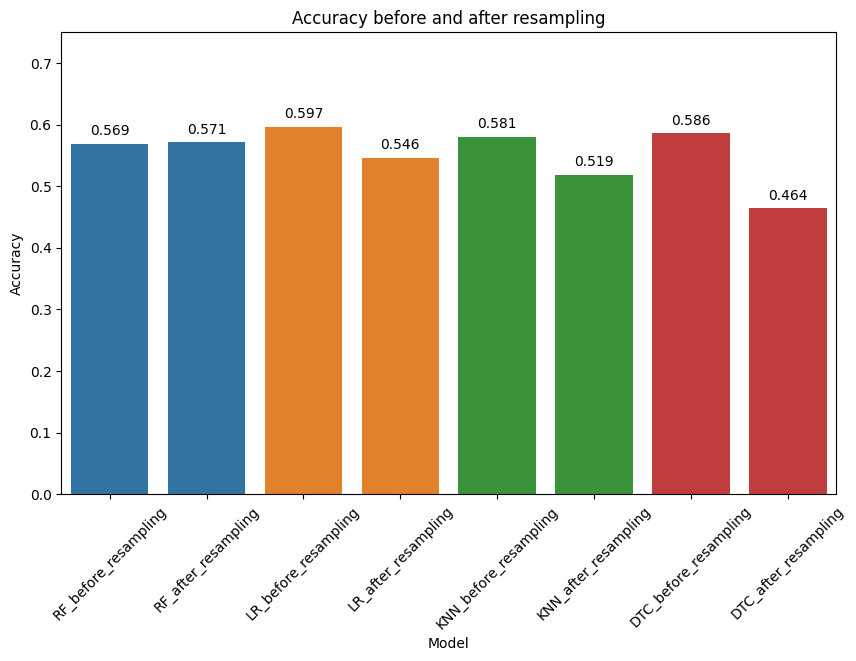

In [112]:
df = pd.DataFrame(algorithms_score_df)

# Remove các hàng có cùng tên model
df = df.drop_duplicates(subset=["model"])
df["model"] = df["model"].str.replace("before_resampling", "_before_resampling")
df["model"] = df["model"].str.replace("after_resampling", "_after_resampling")

# Sắp xếp lại dữ liệu
df.sort_values(by=["model", "score"], inplace=True, ascending=False)

# Tạo một bảng màu tùy chỉnh cho các loại resampling
palette = {
    "RF_before_resampling": "C0",
    "RF_after_resampling": "C0",
    "LR_before_resampling": "C1",
    "LR_after_resampling": "C1",
    "KNN_before_resampling": "C2",
    "KNN_after_resampling": "C2",
    "DTC_before_resampling": "C3",
    "DTC_after_resampling": "C3",
}

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x="model", y="score", data=df, palette=palette)
plt.title("Accuracy before and after resampling")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)

bar_plot.set_ylim(0, 0.75)

# Thêm các con số lên trên các cột
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.3f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')

plt.show()

#### Vẽ ma trận nhầm lẫn của model có độ chính xác cao nhất 

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [17]:
from sklearn.metrics import confusion_matrix

##### Random forest

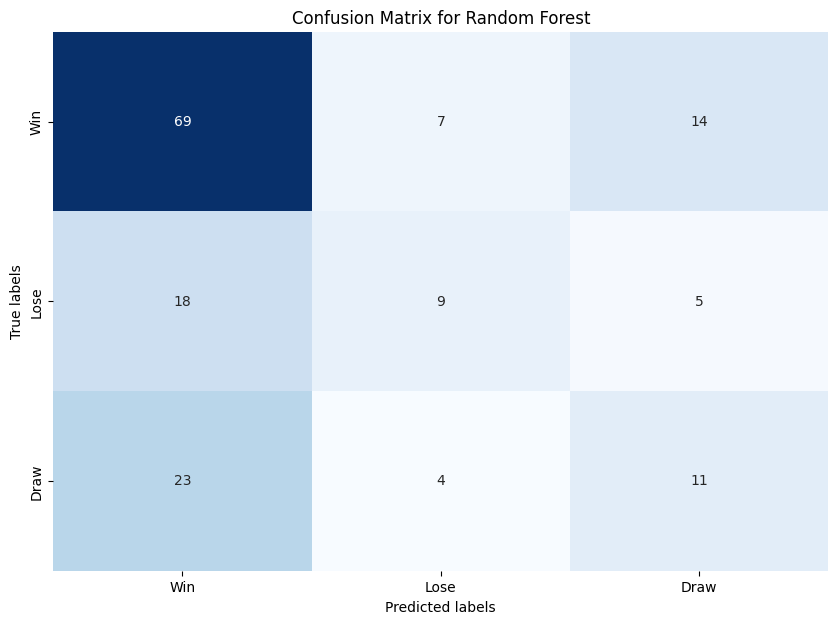

In [27]:
with open('final_best_params/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)
    best_params_RF["RF"].pop("class_weight", None)

rf_model = RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=seed)

y_pred = rf_model.fit(X_train, y_train).predict(X_test)
# Tạo ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Định nghĩa lại nhãn theo thứ tự mong muốn
original_labels = ['Draw', 'Lose', 'Win']
desired_labels = ['Win', 'Lose', 'Draw']
label_mapping = {label: i for i, label in enumerate(original_labels)}
desired_indices = [label_mapping[label] for label in desired_labels]

cm_reordered = cm[desired_indices, :][:, desired_indices]
df_cm = pd.DataFrame(cm_reordered, index=desired_labels, columns=desired_labels)

# Vẽ ma trận confusion với nhãn cụ thể
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

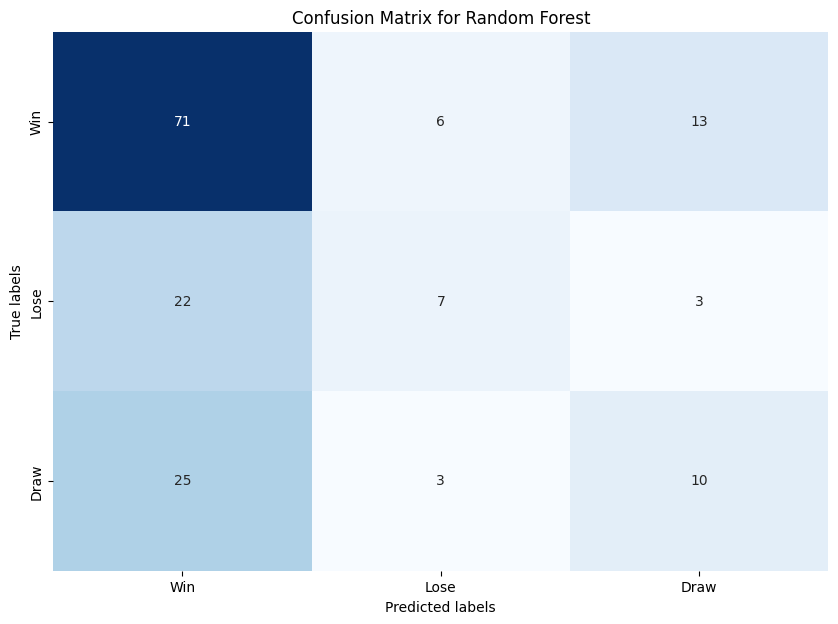

In [28]:
with open('final_best_params/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)
    best_params_RF["RF"]["class_weight"] = "balanced"

rf_model = RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=seed)

y_pred = rf_model.fit(X_train, y_train).predict(X_test)

# Tạo ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Định nghĩa lại nhãn theo thứ tự mong muốn
original_labels = ['Draw', 'Lose', 'Win']
desired_labels = ['Win', 'Lose', 'Draw']
label_mapping = {label: i for i, label in enumerate(original_labels)}
desired_indices = [label_mapping[label] for label in desired_labels]

cm_reordered = cm[desired_indices, :][:, desired_indices]
df_cm = pd.DataFrame(cm_reordered, index=desired_labels, columns=desired_labels)

# Vẽ ma trận confusion với nhãn cụ thể
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

##### Logistic regression

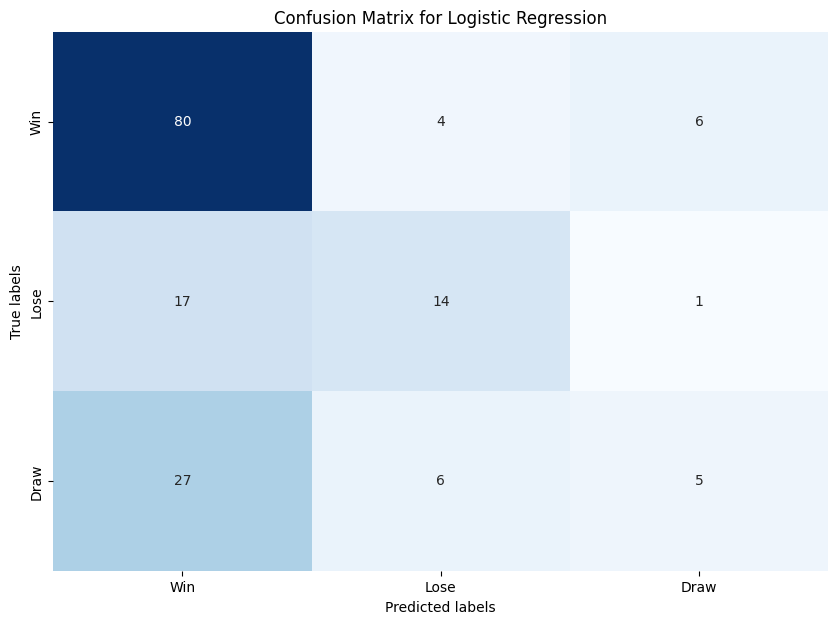

In [22]:
with open('final_best_params/best_params_LR.json', 'r') as f:
    best_params_other = json.load(f)
    best_params_other["LR"].pop("class_weight", None)

lr_model = LogisticRegression(**best_params_other.get("LR", {}), random_state=seed)

y_pred = lr_model.fit(X_train, y_train).predict(X_test)

# Tạo ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Định nghĩa lại nhãn theo thứ tự mong muốn
original_labels = ['Draw', 'Lose', 'Win']
desired_labels = ['Win', 'Lose', 'Draw']
label_mapping = {label: i for i, label in enumerate(original_labels)}
desired_indices = [label_mapping[label] for label in desired_labels]

# Sắp xếp lại ma trận confusion
cm_reordered = cm[:, desired_indices][desired_indices, :]

df_cm = pd.DataFrame(cm_reordered, index=desired_labels, columns=desired_labels)

# Vẽ ma trận confusion với nhãn cụ thể
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

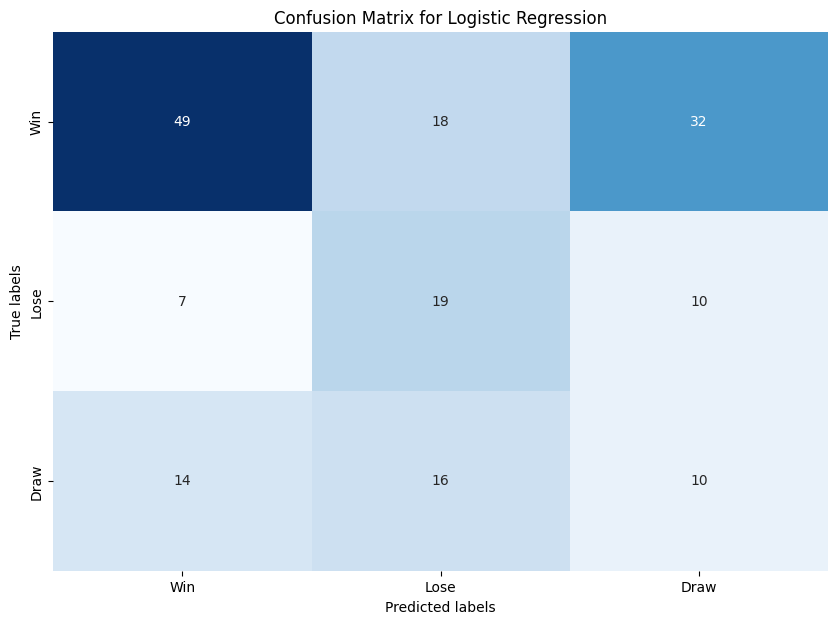

In [152]:
with open('final_best_params/best_params_random_other_balanced.json', 'r') as f:
    best_params_other = json.load(f)
    best_params_other["LR"].pop("class_weight", None)

lr_model = LogisticRegression(**best_params_other.get("LR", {}), class_weight="balanced", random_state=seed)

y_pred = lr_model.fit(X_train, y_train).predict(X_test)

# Tạo ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Định nghĩa lại nhãn theo thứ tự mong muốn
original_labels = ['Draw', 'Lose', 'Win']
desired_labels = ['Win', 'Lose', 'Draw']
label_mapping = {label: i for i, label in enumerate(original_labels)}
desired_indices = [label_mapping[label] for label in desired_labels]

# Sắp xếp lại ma trận confusion
cm_reordered = cm[:, desired_indices][desired_indices, :]

df_cm = pd.DataFrame(cm_reordered, index=desired_labels, columns=desired_labels)

# Vẽ ma trận confusion với nhãn cụ thể
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

### Nhận xét:
- Model random forest cho thấy sự hiệu quả hơn so với model Logistic regression
- Thông qua confusion matrix (sau resampling), ta thấy rằng model random forest dự đoán các mẫu positive tốt hơn so với model logistic regression

=> Ta sẽ chọn model random forest và dùng nó cho dữ liệu test

In [15]:
import pickle
def save_model(model, file_name):
    with open(file_name, "wb") as file:
        pickle.dump(model, file)

In [16]:
# Lưu các encoder
save_model(preprocessor, "final_model/preprocessor.pkl")

In [17]:
# Lưu model vào file joblib
import joblib

with open('final_best_params/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)
    best_params_RF["RF"]["class_weight"] = "balanced"

rf_model = RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=seed)
rf_model.fit(X, y)

save_model(rf_model, "final_model/RF.pkl")

In [18]:
X.columns

Index(['venue_Away', 'venue_Home', 'season_0', 'season_1', 'season_2',
       'season_3', 'season_4', 'win_percent_before_team2', 'win_percent_diff',
       'lose_percent_before_team2', 'head2head_win_percent',
       'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6',
       'ELO_before_match_team2', 'ELO_before_diff',
       'average_score_before_match_team2'],
      dtype='object')